In [1]:
from functools import partial
import numpy as np
import h5py
from unyt import Msun, Myr, Angstrom, erg, s, Hz
from astropy.cosmology import LambdaCDM
import pandas as pd
from schwimmbad import MultiPool
from uncertainties import unumpy
from scipy import integrate

from synthesizer.grid import Grid
from synthesizer.particle import Galaxy
from synthesizer.instruments.filters import FilterCollection

from synthesizer.emission_models import PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw, Calzetti2000, GrainsWD01
from synthesizer.emissions.utils import (
    Ha,
    Hb, 
    O2b,
    O2r,
    O3r,
    O3b,
    O3,
)
from synthesizer.conversions import lnu_to_absolute_mag

np.random.seed(680010)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from lmfit import Model

from utilities import calc_line_corr, calc_line_corr_from_Av, get_flares_LF

cosmo = LambdaCDM(Om0=0.307, Ode0=0.693, H0=67.77, Ob0=0.04825)

In [2]:
def Ha_to_SFR(Ha):
    
    sfr = 10**(-41.36) * Ha
    
    return sfr

def unc_schechter_fn(logL, logLstar, logphistar, alpha):
    
    exponent = (logL - logLstar) * (alpha+1)
    
    return logphistar + exponent + unumpy.log10(np.log(10) * np.e**(- 10**(logL - logLstar) ))

def schechter_fn(logL, logLstar, logphistar, alpha):
    
    exponent = (logL - logLstar) * (alpha+1)
    
    return logphistar + exponent + np.log10(np.log(10) * np.exp(- 10**(logL - logLstar) ))

def fit_schechter(phi, logL):
    
    model = Model(schechter_fn)

    model.set_param_hint('alpha', min=-2.5, max=-0.5)
    model.set_param_hint('logLstar', min=1., max=2.5)
    model.set_param_hint('logphistar', min=-5, max=-2.5)    

    result = model.fit(phi, logL=logL, logLstar=2., logphistar=-2.5, alpha=-1.5, method='emcee', fit_kws={'steps':5000, 'burn':1000, 'nwalkers':200, 'thin':20})
    
    return result

def get_data(ii, tag):

    num = str(ii)

    if len(num) == 1:
        num =  '0'+num

    sim = "./data/flares_sfe_data.hdf5"
    num = num+'/'

    with h5py.File(sim, 'r') as hf:
        Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
        MassweightedZ = np.array(hf[num+tag+'/Galaxy/Metallicity'].get('CurrentMassWeightedStellarZ'), dtype = np.float32)
        MFUVatt = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('FUV'), dtype = np.float32) * erg / s / Hz
        MFUVint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('FUV'), dtype = np.float32) * erg / s / Hz

        Av = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('V'), dtype = np.float32) / np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('V'), dtype = np.float32)
        Av = -2.5 * np.log10(Av)

        Halpha = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbeta = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('Luminosity'), dtype = np.float64)
        Halphaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbetaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI4861'].get('Luminosity'), dtype = np.float64)      


    ok = (Halphaint>0) * (lnu_to_absolute_mag(MFUVatt)<-17)

    return Mstar[ok], MFUVatt[ok], Halpha[ok], Hbeta[ok], Halphaint[ok], Hbetaint[ok], MassweightedZ[ok], MFUVint[ok], Av[ok]

In [3]:
# Define the grid
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps"
grid_dir = "./data/" 
grid = Grid(grid_name, grid_dir=grid_dir)

Zsun = 0.014
req_lines = {'H 1 6562.80A': 'Halpha',
             'H 1 4861.32A': 'Hbeta',
             'O 2 3726.03A,O 2 3728.81A': '[OII]3727,29',
             'O 3 4958.91A': '[OIII]4959',
             'O 3 5006.84A': '[OIII]5007',
             'Ne 3 3868.76A': 'NeIII3869'
}

tophats = {
    "UV1500": {"lam_eff": 1500*Angstrom, "lam_fwhm": 300*Angstrom},
    "UV2800": {"lam_eff": 2800*Angstrom, "lam_fwhm": 300*Angstrom},
}

filters = FilterCollection(
    filter_codes=[f'Generic/Johnson.V'],
    tophat_dict=tophats,
    new_lam=grid.lam
)

li = [
       Ha,
       Hb, 
   ]

lam_Ha = 6562.80 * Angstrom
lam_Hb = 4861.32 * Angstrom

In [4]:
redshift = 6.
# Number of star particles
n = 100
ages = np.random.uniform(1, 30, size=n) * Myr
Z = 10**np.random.uniform(-3, -2, size=n)
mass = 1e6*np.random.uniform(1, 5, n) * Msun 

print (r'log$_{10}$(M$_{\star}$/M$_{\odot}$): ', np.log10(np.sum(mass).to('Msun')))

# Dust distributions
max_tau = 15
mu, sigma = 0.1, 0.2
nsigma = np.arange(0,max_tau,2)
num_gals = len(nsigma)

# Property holders
logOH = np.zeros(4)
lum_int = np.zeros(4, dtype=object)
line_int = np.zeros(4, dtype=object)
sed_int = np.zeros(4, dtype=object)

line_emergent = np.zeros((4, num_gals), dtype=object)
sed_emergent = np.zeros((4, num_gals), dtype=object)
lum_att = np.zeros((4, num_gals))
att_curve = np.zeros((4, num_gals, len(grid.lam)))
Av = np.zeros((4, num_gals))
#intrinsic
Luv = np.zeros(4)
Halpha_frac_dust = np.zeros((4, num_gals))
Halpha_frac_Avcorr = np.zeros((4, num_gals))
Halpha_frac_balmercorr = np.zeros((4, num_gals))

# Vary everything
gal = Galaxy(redshift=redshift)
gal.load_stars(
    ages=ages,
    metallicities=Z,
    initial_masses=mass 
)
ok = gal.stars.ages<=10*Myr
Zmean = np.sum(gal.stars.initial_masses[ok] * gal.stars.metallicities[ok]) / np.sum(gal.stars.initial_masses[ok])
Agemean = np.sum(gal.stars.initial_masses[ok] * gal.stars.ages[ok]) / np.sum(gal.stars.initial_masses[ok])

print (Zmean, Agemean)

# Keep everything fixed
gal_const = Galaxy(redshift=redshift)
gal_const.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary age
gal_vary_age = Galaxy(redshift=redshift)
gal_vary_age.load_stars(
    ages=ages,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary metallicity
gal_vary_Z = Galaxy(redshift=redshift)
gal_vary_Z.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=Z,
    initial_masses=mass 
)

all_gals = [gal_const, gal_vary_age, gal_vary_Z, gal]

for jj, kk in enumerate(all_gals):
    print ("Galaxy number: ", jj)
    ok = kk.stars.ages<=10*Myr
    Zmean = np.sum(kk.stars.initial_masses[ok] * kk.stars.metallicities[ok]) / np.sum(kk.stars.initial_masses[ok])    
    logOH[jj] = 8.69 + np.log10(Zmean/Zsun)

    for ii in range(num_gals):
        tau_v = mu + np.random.normal(0, nsigma[ii], n)
        tau_v[tau_v<0] = 0.01
        emodel = PacmanEmission(
            grid=grid,
            tau_v=tau_v,
            dust_curve=PowerLaw(),
            per_particle=True
        )   
    
        kk.stars.get_spectra(emission_model=emodel)    
        kk.stars.get_lines(li,
            emodel
        )        
        
        line_emergent[jj][ii] = kk.stars.lines['emergent']
        kk.stars.spectra['emergent'].get_fnu(cosmo=cosmo, z=redshift)   
        tmp = kk.stars.spectra['emergent'].get_photo_lnu(filters, verbose=False)
        lum_att[jj][ii] = tmp['Generic/Johnson.V']
        
        sed_emergent[jj][ii] = kk.stars.spectra['emergent']
        att_curve[jj][ii] = -2.5 * np.log10(kk.stars.spectra['emergent'].luminosity/kk.stars.spectra['intrinsic'].luminosity)

    line_int[jj] = kk.stars.lines['intrinsic']    
    lum_int[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['Generic/Johnson.V']    
    Luv[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['UV1500'] 
    sed_int[jj] = kk.stars.spectra['intrinsic']

    Av[jj] = -2.5 * np.log10(lum_att[jj]/lum_int[jj])
    
for jj, kk in enumerate(all_gals):
    for ii in range(num_gals):
        Halpha_frac_dust[jj][ii] = line_emergent[jj][ii]['Ha'].luminosity / line_int[jj]['Ha'].luminosity
        
        Halpha_frac_Avcorr[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, Av[jj][ii], slope=0) / line_int[jj]['Ha'].luminosity
        
        Halpha_frac_balmercorr[jj][ii] = calc_line_corr(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, line_emergent[jj][ii]['Ha'].luminosity/line_emergent[jj][ii]['Hb'].luminosity) / line_int[jj]['Ha'].luminosity

log$_{10}$(M$_{\star}$/M$_{\odot}$):  8.481938530547351
0.0043673333344749635 dimensionless 5268099.2695223 yr
Galaxy number:  0


/Users/ap629AA/Astro/synthesizer/synthesizer/src/synthesizer/particle/galaxy.py:260: RuntimeWarning: Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  self.calculate_integrated_stellar_properties()
/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


Galaxy number:  1
Galaxy number:  2
Galaxy number:  3


/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_4084/2256677506.py:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Halpha_frac_dust[jj][ii] = line_emergent[jj][ii]['Ha'].luminosity / line_int[jj]['Ha'].luminosity
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_4084/2256677506.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Halpha_frac_Avcorr[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha

In [5]:
# Star formation and metal enrichment history
title = [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']
for jj, kk in enumerate(all_gals):
    kk.stars.get_sfzh(log10ages=np.arange(6,7.51,0.1), log10metallicities=np.arange(-3.5,-1.4,0.5))
    fig, ax = kk.stars.plot_sfzh(show=False)
    ax.xaxis.label.set_size(13)
    ax.yaxis.label.set_size(13)
    if jj>0:
        ax.set_ylabel('')
    fig.suptitle(title[jj], fontsize=13)
    fig.savefig(F'plots/sfzh_{jj}.png', bbox_inches='tight', dpi=300)
    plt.close()
    

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_4084/559827656.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_4084/559827656.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']


In [6]:
logOH

array([8.1840883 , 8.1840883 , 8.13182314, 8.1840883 ])

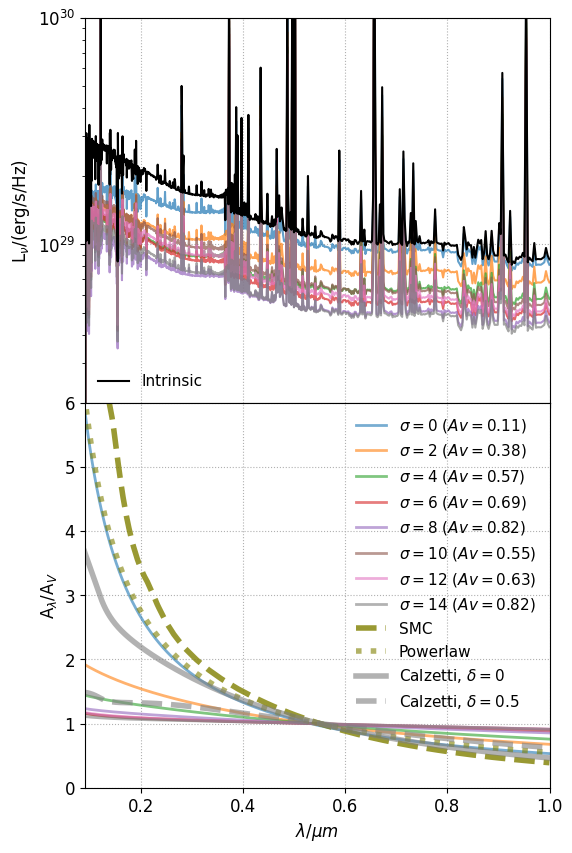

In [7]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(6, 10), sharex=True, sharey=False, facecolor='w', edgecolor='k')
axs = axs.ravel()

req_gal = 0

req_sed = sed_emergent[req_gal]
req_att_curve = att_curve[req_gal]
req_Av = Av[req_gal]

for ii in range(num_gals):
    color = plt.cm.tab10(ii) 
    ok = np.where(grid.lam<=1e4 * Angstrom)[0]
    
    axs[0].plot(grid.lam[ok]/1e4, req_sed[ii].lnu[ok], color=color, alpha=0.7)
    axs[1].plot(grid.lam[ok]/1e4, req_att_curve[ii][ok]/req_Av[ii], label=rF'$\sigma={nsigma[ii]}$ $(Av={np.round(Av[0][ii],2)})$', alpha=0.6, lw=2, color=color)    

axs[0].plot(grid.lam[ok]/1e4, sed_int[req_gal].lnu[ok], color='black', label='Intrinsic')

c = GrainsWD01(model='SMC')
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='SMC', alpha=0.8, ls='dashed', lw=4, color='olive')

c = PowerLaw()
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='Powerlaw', alpha=0.6, ls='dotted', lw=4, color='olive')

c = Calzetti2000()
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label=r'Calzetti, $\delta=0$', alpha=0.6, ls='solid', lw=4, color='grey')

c = Calzetti2000(slope=0.5)
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label=r'Calzetti, $\delta=0.5$', alpha=0.6, ls='dashed', lw=4, color='grey')

for ax in axs:
    ax.grid(ls='dotted')
    ax.legend(frameon=False, fontsize=11) 
    ax.set_xlim(0.09,1)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
    
axs[0].set_ylabel(r'L$_{\nu}$/(erg/s/Hz)', fontsize=12)
axs[0].set_ylim(2e28, 1e30)
axs[0].set_yscale('log')

axs[1].set_xlabel(r'$\lambda$/$\mu m$', fontsize=12)
axs[1].set_ylim(0,6)
axs[1].set_ylabel(r'A$_{\lambda}$/A$_{V}$', fontsize=12)

fig.subplots_adjust(hspace=0,wspace=0)   
plt.savefig('plots/toy_att_curves.png', dpi=300, bbox_inches='tight')   
plt.show()

<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_4084/1682839267.py:32: SyntaxWarning: invalid escape sequence '\m'
  twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=False, fontsize=11, loc=(-0.05,1.01), ncols=2, framealpha=0.4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_4084/1682839267.py:32: SyntaxWarning: invalid escape sequence '\m'
  twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=False, fontsize=11, loc=(-0.05,1.01), ncols=2, framealpha=0.4)


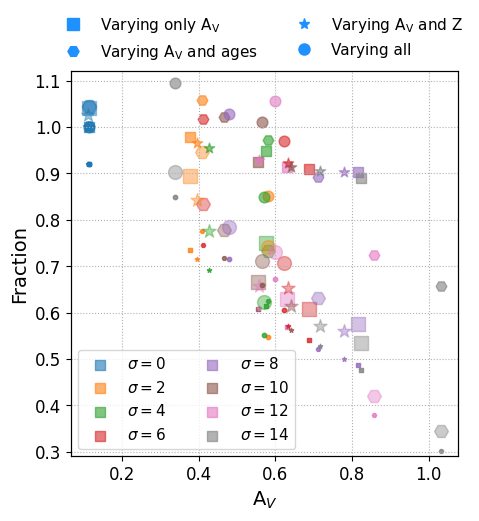

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), sharex=True, sharey=True, facecolor='w', edgecolor='k')
twinax = ax.twinx()

markers = ['s', 'H', '*', 'o']
custom = [Line2D([], [], marker=ii, markersize=8, color='dodgerblue', linestyle='None') for ii in markers]

for jj in range(4):    
    for ii in range(num_gals):
        color = plt.cm.tab10(ii)
        
      
        ax.scatter(Av[jj][ii], Halpha_frac_dust[jj][ii], color=color, s=10, marker=markers[jj], alpha=0.8)
        
        if jj==0:
            ax.scatter(Av[jj][ii], Halpha_frac_Avcorr[jj][ii], color=color, s=60, marker=markers[jj], alpha=0.6, label=rF'$\sigma={nsigma[ii]}$')
        else:
            ax.scatter(Av[jj][ii], Halpha_frac_Avcorr[jj][ii], color=color, s=60, marker=markers[jj], alpha=0.6)
            
        ax.scatter(Av[jj][ii], Halpha_frac_balmercorr[jj][ii], color=color, s=100, marker=markers[jj], alpha=0.4)


ax.set_xlabel(r'A$_{V}$', fontsize=14)
ax.set_ylabel(r'Fraction', fontsize=14)
ax.set_ylim(0.29, 1.12)
ax.grid(ls='dotted')
ax.legend(frameon=True, fontsize=11, ncols=2, loc='lower left') 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)
twinax.set_yticks([])
twinax.set_yticklabels([])

twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=False, fontsize=11, loc=(-0.05,1.01), ncols=2, framealpha=0.4)
twinax.set_yticks([])
twinax.set_yticklabels([])

plt.savefig('plots/toy_sfr_frac.png', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/1300163648.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/1300163648.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvq

5.0 int [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 8
    # variables        = 3
    chi-square         = 0.24210814
    reduced chi-square = 0.04842163
    Akaike info crit   = -21.9824987
    Bayesian info crit = -21.7441741
    R-squared          = 0.97542264
[[Variables]]
    logLstar:    1.99874896 +/- 0.27273919 (13.65%) (init = 2)
    logphistar: -3.90579006 +/- 0.65295584 (16.72%) (init = -2.5)
    alpha:      -1.79110230 +/- 0.50367477 (28.12%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7650
    C(logphistar, alpha)    = +0.6267
    C(logLstar, alpha)      = -0.4767


100%|██████████| 5000/5000 [00:17<00:00, 287.06it/s]


5.0 obs [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 8
    # variables        = 3
    chi-square         = 0.81665447
    reduced chi-square = 0.16333089
    Akaike info crit   = -12.2558459
    Bayesian info crit = -12.0175213
    R-squared          = 0.95602254
[[Variables]]
    logLstar:    1.80319874 +/- 0.21253275 (11.79%) (init = 2)
    logphistar: -4.08031165 +/- 0.61221767 (15.00%) (init = -2.5)
    alpha:      -1.94256930 +/- 0.45853698 (23.60%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7740
    C(logphistar, alpha)    = +0.5389
    C(logLstar, alpha)      = -0.4664


100%|██████████| 5000/5000 [00:17<00:00, 284.77it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/4205277553.py:148: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


5.0 Av [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 9
    # variables        = 3
    chi-square         = 0.28810558
    reduced chi-square = 0.04801760
    Akaike info crit   = -24.9748756
    Bayesian info crit = -24.3832019
    R-squared          = 0.98647980
[[Variables]]
    logLstar:    2.05632859 +/- 0.18792766 (9.14%) (init = 2)
    logphistar: -4.13230745 +/- 0.57646820 (13.95%) (init = -2.5)
    alpha:      -1.87672023 +/- 0.45336852 (24.16%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7704
    C(logphistar, alpha)    = +0.6189
    C(logLstar, alpha)      = -0.5326


100%|██████████| 5000/5000 [00:17<00:00, 291.89it/s]


5.0 balmer [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 8
    # variables        = 3
    chi-square         = 0.22765200
    reduced chi-square = 0.04553040
    Akaike info crit   = -22.4750294
    Bayesian info crit = -22.2367047
    R-squared          = 0.98733569
[[Variables]]
    logLstar:    1.78110989 +/- 0.22916290 (12.87%) (init = 2)
    logphistar: -3.84521684 +/- 0.66416995 (17.27%) (init = -2.5)
    alpha:      -1.88962782 +/- 0.50199648 (26.57%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.8009
    C(logphistar, alpha)    = +0.5693
    C(logLstar, alpha)      = -0.5186


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/1300163648.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/1300163648.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvq

6.0 int [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 8
    # variables        = 3
    chi-square         = 1.19381345
    reduced chi-square = 0.23876269
    Akaike info crit   = -9.21831020
    Bayesian info crit = -8.97998557
    R-squared          = 0.87827122
[[Variables]]
    logLstar:    2.02954603 +/- 0.25838915 (12.73%) (init = 2)
    logphistar: -4.17001243 +/- 0.58391437 (14.00%) (init = -2.5)
    alpha:      -1.76390920 +/- 0.47972495 (27.20%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7149
    C(logphistar, alpha)    = +0.5928
    C(logLstar, alpha)      = -0.3910


100%|██████████| 5000/5000 [00:16<00:00, 296.78it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/4205277553.py:118: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


6.0 obs [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.19300402
    reduced chi-square = 0.04825101
    Akaike info crit   = -19.1366808
    Bayesian info crit = -19.2989504
    R-squared          = 0.98727236
[[Variables]]
    logLstar:    1.45502200 +/- 0.23148958 (15.91%) (init = 2)
    logphistar: -3.70172488 +/- 0.67339183 (18.19%) (init = -2.5)
    alpha:      -1.79647908 +/- 0.57487110 (32.00%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7903
    C(logLstar, alpha)      = -0.4847
    C(logphistar, alpha)    = +0.4829


100%|██████████| 5000/5000 [00:17<00:00, 280.18it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/4205277553.py:148: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


6.0 Av [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 8
    # variables        = 3
    chi-square         = 0.34417729
    reduced chi-square = 0.06883546
    Akaike info crit   = -19.1683193
    Bayesian info crit = -18.9299947
    R-squared          = 0.97728005
[[Variables]]
    logLstar:    1.80505621 +/- 0.23128892 (12.81%) (init = 2)
    logphistar: -3.98637067 +/- 0.63736814 (15.99%) (init = -2.5)
    alpha:      -1.78347549 +/- 0.52744407 (29.57%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7794
    C(logphistar, alpha)    = +0.5870
    C(logLstar, alpha)      = -0.5124


100%|██████████| 5000/5000 [00:16<00:00, 294.77it/s]


6.0 balmer [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.23733089
    reduced chi-square = 0.05933272
    Akaike info crit   = -17.6894707
    Bayesian info crit = -17.8517402
    R-squared          = 0.98025934
[[Variables]]
    logLstar:    1.54326159 +/- 0.27431846 (17.78%) (init = 2)
    logphistar: -3.69686232 +/- 0.69259910 (18.73%) (init = -2.5)
    alpha:      -1.77221457 +/- 0.57688758 (32.55%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7931
    C(logphistar, alpha)    = +0.5107
    C(logLstar, alpha)      = -0.4600


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/1300163648.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/1300163648.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvq

7.0 int [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 8
    # variables        = 3
    chi-square         = 0.25837897
    reduced chi-square = 0.05167579
    Akaike info crit   = -21.4621555
    Bayesian info crit = -21.2238309
    R-squared          = 0.98403590
[[Variables]]
    logLstar:    1.76495309 +/- 0.20793812 (11.78%) (init = 2)
    logphistar: -4.09918470 +/- 0.59218399 (14.45%) (init = -2.5)
    alpha:      -1.75610758 +/- 0.52995981 (30.18%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7598
    C(logphistar, alpha)    = +0.5640
    C(logLstar, alpha)      = -0.5040


100%|██████████| 5000/5000 [00:17<00:00, 291.85it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/4205277553.py:118: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


7.0 obs [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.25583096
    reduced chi-square = 0.06395774
    Akaike info crit   = -17.1640396
    Bayesian info crit = -17.3263092
    R-squared          = 0.99028538
[[Variables]]
    logLstar:    1.24879318 +/- 0.14647704 (11.73%) (init = 2)
    logphistar: -3.60176912 +/- 0.58256466 (16.17%) (init = -2.5)
    alpha:      -1.72203744 +/- 0.61428653 (35.67%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7523
    C(logLstar, alpha)      = -0.5577
    C(logphistar, alpha)    = +0.3801


100%|██████████| 5000/5000 [00:17<00:00, 290.05it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/4205277553.py:148: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


7.0 Av [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.30422636
    reduced chi-square = 0.07605659
    Akaike info crit   = -15.9512539
    Bayesian info crit = -16.1135234
    R-squared          = 0.96212303
[[Variables]]
    logLstar:    1.69363253 +/- 0.30233423 (17.85%) (init = 2)
    logphistar: -4.06269767 +/- 0.63631778 (15.66%) (init = -2.5)
    alpha:      -1.71811502 +/- 0.54242660 (31.57%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7309
    C(logphistar, alpha)    = +0.5063
    C(logLstar, alpha)      = -0.3459


100%|██████████| 5000/5000 [00:17<00:00, 291.25it/s]


7.0 balmer [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.23198177
    reduced chi-square = 0.05799544
    Akaike info crit   = -17.8490464
    Bayesian info crit = -18.0113160
    R-squared          = 0.97933170
[[Variables]]
    logLstar:    1.55542921 +/- 0.26364670 (16.95%) (init = 2)
    logphistar: -3.90492156 +/- 0.65833929 (16.86%) (init = -2.5)
    alpha:      -1.74348198 +/- 0.57092805 (32.75%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7658
    C(logphistar, alpha)    = +0.5009
    C(logLstar, alpha)      = -0.4355


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/1300163648.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/1300163648.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvq

8.0 int [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.49526159
    reduced chi-square = 0.12381540
    Akaike info crit   = -12.5400554
    Bayesian info crit = -12.7023250
    R-squared          = 0.93582336
[[Variables]]
    logLstar:    1.68329544 +/- 0.28280366 (16.80%) (init = 2)
    logphistar: -4.21532149 +/- 0.58033104 (13.77%) (init = -2.5)
    alpha:      -1.66313062 +/- 0.54554527 (32.80%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.6994
    C(logphistar, alpha)    = +0.4721
    C(logLstar, alpha)      = -0.3116


100%|██████████| 5000/5000 [00:16<00:00, 301.86it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/4205277553.py:118: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


8.0 obs [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 6
    # variables        = 3
    chi-square         = 0.42580579
    reduced chi-square = 0.14193526
    Akaike info crit   = -9.87318846
    Bayesian info crit = -10.4979100
    R-squared          = 0.93645415
[[Variables]]
    logLstar:    1.41273279 +/- 0.31740541 (22.47%) (init = 2)
    logphistar: -4.06526017 +/- 0.62081554 (15.27%) (init = -2.5)
    alpha:      -1.70471935 +/- 0.57467787 (33.71%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.6793
    C(logphistar, alpha)    = +0.3352
    C(logLstar, alpha)      = -0.1888


100%|██████████| 5000/5000 [00:17<00:00, 287.97it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/4205277553.py:148: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


8.0 Av [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.51226078
    reduced chi-square = 0.12806520
    Akaike info crit   = -12.3038212
    Bayesian info crit = -12.4660907
    R-squared          = 0.94154525
[[Variables]]
    logLstar:    1.64094143 +/- 0.26454621 (16.12%) (init = 2)
    logphistar: -4.24094450 +/- 0.56690756 (13.37%) (init = -2.5)
    alpha:      -1.69506486 +/- 0.54868367 (32.37%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.6968
    C(logphistar, alpha)    = +0.4547
    C(logLstar, alpha)      = -0.3115


100%|██████████| 5000/5000 [00:17<00:00, 289.60it/s]


8.0 balmer [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.50065498
    reduced chi-square = 0.12516374
    Akaike info crit   = -12.4642376
    Bayesian info crit = -12.6265071
    R-squared          = 0.95251162
[[Variables]]
    logLstar:    1.57896495 +/- 0.24602012 (15.58%) (init = 2)
    logphistar: -4.19044105 +/- 0.58424839 (13.94%) (init = -2.5)
    alpha:      -1.74536509 +/- 0.55218580 (31.64%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7142
    C(logphistar, alpha)    = +0.4568
    C(logLstar, alpha)      = -0.3565


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/1300163648.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/1300163648.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvq

9.0 int [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.66798822
    reduced chi-square = 0.16699706
    Akaike info crit   = -10.4457642
    Bayesian info crit = -10.6080338
    R-squared          = 0.93496982
[[Variables]]
    logLstar:    1.56801568 +/- 0.22138512 (14.12%) (init = 2)
    logphistar: -4.34287092 +/- 0.51561367 (11.87%) (init = -2.5)
    alpha:      -1.71034479 +/- 0.54743991 (32.01%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.6697
    C(logphistar, alpha)    = +0.3987
    C(logLstar, alpha)      = -0.3026


100%|██████████| 5000/5000 [00:16<00:00, 300.20it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/4205277553.py:118: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


9.0 obs [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 6
    # variables        = 3
    chi-square         = 0.60264918
    reduced chi-square = 0.20088306
    Akaike info crit   = -7.78907702
    Bayesian info crit = -8.41379862
    R-squared          = 0.91104867
[[Variables]]
    logLstar:    1.39075707 +/- 0.28856068 (20.75%) (init = 2)
    logphistar: -4.23925853 +/- 0.55893124 (13.18%) (init = -2.5)
    alpha:      -1.68140963 +/- 0.56945369 (33.87%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.6333
    C(logphistar, alpha)    = +0.2793
    C(logLstar, alpha)      = -0.1331


100%|██████████| 5000/5000 [00:17<00:00, 285.04it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/4205277553.py:148: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


9.0 Av [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.74335417
    reduced chi-square = 0.18583854
    Akaike info crit   = -9.69744977
    Bayesian info crit = -9.85971933
    R-squared          = 0.92938405
[[Variables]]
    logLstar:    1.55742758 +/- 0.21713789 (13.94%) (init = 2)
    logphistar: -4.35864070 +/- 0.50554987 (11.60%) (init = -2.5)
    alpha:      -1.70816672 +/- 0.54216597 (31.74%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.6637
    C(logphistar, alpha)    = +0.3904
    C(logLstar, alpha)      = -0.3014


100%|██████████| 5000/5000 [00:17<00:00, 289.44it/s]


9.0 balmer [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.37492601
    reduced chi-square = 0.09373150
    Akaike info crit   = -14.4885570
    Bayesian info crit = -14.6508266
    R-squared          = 0.97498888
[[Variables]]
    logLstar:    1.42962646 +/- 0.18566925 (12.99%) (init = 2)
    logphistar: -4.21035986 +/- 0.55053073 (13.08%) (init = -2.5)
    alpha:      -1.74190221 +/- 0.57287715 (32.89%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7108
    C(logLstar, alpha)      = -0.4469
    C(logphistar, alpha)    = +0.3943


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/1300163648.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/1300163648.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvq

10.0 int [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.78448140
    reduced chi-square = 0.19612035
    Akaike info crit   = -9.32049793
    Bayesian info crit = -9.48276748
    R-squared          = 0.94358601
[[Variables]]
    logLstar:    1.42845291 +/- 0.17196682 (12.04%) (init = 2)
    logphistar: -4.37200188 +/- 0.48152787 (11.01%) (init = -2.5)
    alpha:      -1.67669409 +/- 0.57475235 (34.28%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.6604
    C(logLstar, alpha)      = -0.3956
    C(logphistar, alpha)    = +0.3461


100%|██████████| 5000/5000 [00:16<00:00, 303.27it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/4205277553.py:118: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


10.0 obs [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 6
    # variables        = 3
    chi-square         = 1.12535261
    reduced chi-square = 0.37511754
    Akaike info crit   = -4.04197833
    Bayesian info crit = -4.66669992
    R-squared          = 0.90506981
[[Variables]]
    logLstar:    1.20047477 +/- 0.17404579 (14.50%) (init = 2)
    logphistar: -4.27099884 +/- 0.49880013 (11.68%) (init = -2.5)
    alpha:      -1.76316576 +/- 0.56450228 (32.02%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.5736
    C(logLstar, alpha)      = -0.1905
    C(logphistar, alpha)    = +0.1472


100%|██████████| 5000/5000 [00:17<00:00, 284.00it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6520/4205277553.py:148: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


10.0 Av [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 7
    # variables        = 3
    chi-square         = 0.94195742
    reduced chi-square = 0.23548935
    Akaike info crit   = -8.03993750
    Bayesian info crit = -8.20220705
    R-squared          = 0.93330830
[[Variables]]
    logLstar:    1.42254153 +/- 0.16781199 (11.80%) (init = 2)
    logphistar: -4.40672053 +/- 0.46073951 (10.46%) (init = -2.5)
    alpha:      -1.67236268 +/- 0.57528121 (34.40%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.6443
    C(logLstar, alpha)      = -0.3956
    C(logphistar, alpha)    = +0.3340


100%|██████████| 5000/5000 [00:16<00:00, 300.12it/s]


10.0 balmer [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 6
    # variables        = 3
    chi-square         = 0.88519267
    reduced chi-square = 0.29506422
    Akaike info crit   = -5.48225652
    Bayesian info crit = -6.10697811
    R-squared          = 0.90044483
[[Variables]]
    logLstar:    1.28239155 +/- 0.22615419 (17.64%) (init = 2)
    logphistar: -4.26117341 +/- 0.52716021 (12.37%) (init = -2.5)
    alpha:      -1.69725688 +/- 0.57724152 (34.01%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.6056
    C(logphistar, alpha)    = +0.2235
    C(logLstar, alpha)      = -0.1686


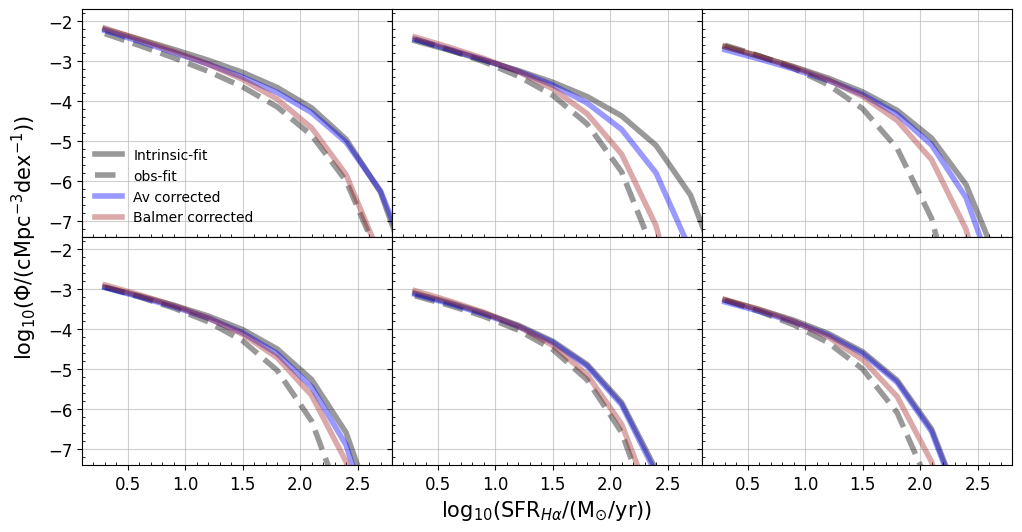

In [19]:
h = 0.6777
vol = (4/3)*np.pi*(14/h)**3
quantiles = [0.16,0.50,0.84]
df = pd.read_csv('./data/weights_grid.txt')
weights = np.array(df['weights'])

sfrbins = np.arange(0.3, 3.3, 0.3)
bincen = (sfrbins[1:]+sfrbins[:-1])/2.
binwidth = sfrbins[1:] - sfrbins[:-1]

sfrbinshigh = np.arange(1.5, 3.3, 0.3)
bincenhigh = (sfrbinshigh[1:]+sfrbinshigh[:-1])/2.
binwidthhigh = sfrbinshigh[1:] - sfrbinshigh[:-1]

tags = ['010_z005p000', '009_z006p000', '008_z007p000', '007_z008p000', '006_z009p000', '005_z010p000']

obsc_frac = np.zeros((2, len(tags)))
obsc_frac_err = np.zeros((2, len(tags)))

sfrd_frac_Av = np.zeros((2, len(tags)))
sfrd_frac_Av_err = np.zeros((2, len(tags)))

sfrd_frac_balmer = np.zeros((2, len(tags)))
sfrd_frac_balmer_err = np.zeros((2, len(tags)))

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 6), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs = axs.ravel()

for ii, tag in enumerate(tags):
       
    z = float(tag[5:].replace('p','.'))

    func    = partial(get_data, tag=tag)
    pool    = MultiPool(processes=4)
    dat     = np.array(list(pool.map(func, np.arange(0,40))), dtype='object')
    pool.close()

    Mstar = np.log10(np.concatenate(dat[:,0]))
    MFUVatt = np.concatenate(dat[:,1])
    Halpha = np.concatenate(dat[:,2])
    Hbeta = np.concatenate(dat[:,3])
    Halphaint = np.concatenate(dat[:,4])
    Hbetaint = np.concatenate(dat[:,5])
    MassweightedZ = np.concatenate(dat[:,6])
    MFUVint = np.concatenate(dat[:,7])
    Av = np.concatenate(dat[:,8])
    
    Halpha_Av = calc_line_corr_from_Av(Halpha * erg/s, lam_Ha, Av, slope=0).to_value()
    Halpha_balmer =  calc_line_corr(Halpha * erg/s, lam_Ha, Halpha/Hbeta, slope=0).to_value() 
    
    sfr_int = np.log10(Ha_to_SFR(Halphaint))
    sfr_dust = np.log10(Ha_to_SFR(Halpha))
    sfr_Av = np.log10(Ha_to_SFR(Halpha_Av))
    sfr_balmer = np.log10(Ha_to_SFR(Halpha_balmer))
    
    tot_gals = len(Mstar)
    
    n = np.array([])
    for jj in range(40):
        n = np.append(n, len(dat[jj][0]))

    #Make the SFR distribution function, integrate the different ratio to get the recovered fraction
   
    hist, M, err = get_flares_LF(sfr_int, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    # axs[ii].plot(bincen, np.log10(phi), lw=4, alpha=0.4, ls='solid', label='Intrinsic', color='black')
    # axs[ii].fill_between(bincen[ok], np.log10(phi[ok]-phierr[ok]), np.log10(phi[ok]+phierr[ok]), alpha=0.25, color='black')
    
    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi[ok]), bincen[ok])
    print (z, 'int', result.fit_report())
    fit = np.array([*result.best_values.values()])
    fiterr = np.array(result.flatchain.std())
    f = unc_schechter_fn(sfrbins, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))
    
    tot = integrate.simpson(10**f, sfrbins)    
    axs[ii].plot(sfrbins, unumpy.nominal_values(f), lw=4, alpha=0.4, ls='solid', label='Intrinsic-fit', color='black')
    f = unc_schechter_fn(sfrbinshigh, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))
    tothigh = integrate.simpson(10**f, sfrbinshigh)
    
    
    hist, M, err = get_flares_LF(sfr_dust, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    # axs[ii].plot(bincen, np.log10(phi), lw=4, alpha=0.4, ls='dashed', label='Observed', color='black')
    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi[ok]), bincen[ok])
    print (z, 'obs', result.fit_report())
    fit = np.array([*result.best_values.values()])
    fiterr = np.array(result.flatchain.std())
    f = unc_schechter_fn(sfrbins, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))   
    axs[ii].plot(sfrbins, unumpy.nominal_values(f), lw=4, alpha=0.4, ls='dashed', label='obs-fit', color='black') 
    tmp = integrate.simpson(10**f, sfrbins) / tot    
    obsc_frac[0][ii] = unumpy.nominal_values(tmp)
    obsc_frac_err[0][ii] = unumpy.std_devs(tmp)
    f = unc_schechter_fn(sfrbinshigh, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))
    tmp = integrate.simpson(10**f, sfrbinshigh) / tothigh
    obsc_frac[1][ii] = unumpy.nominal_values(tmp)
    obsc_frac_err[1][ii] = unumpy.std_devs(tmp)
    # axs[ii].fill_between(bincen[ok], np.log10(phi[ok]-phierr[ok]), np.log10(phi[ok]+phierr[ok]), alpha=0.25, color='black')
    # tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincen) / tot
    # obsc_frac[0][ii] = unumpy.nominal_values(tmp)
    # obsc_frac_err[0][ii] = unumpy.std_devs(tmp)
        
    # hist, M, err = get_flares_LF(sfr_dust, weights, sfrbinshigh, n)
    # phi, phierr = M/(binwidthhigh*vol), err/(binwidthhigh*vol)
    # tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincenhigh) / tothigh
    # obsc_frac[1][ii] = unumpy.nominal_values(tmp)
    # obsc_frac_err[1][ii] = unumpy.std_devs(tmp)
    
    
    hist, M, err = get_flares_LF(sfr_Av, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    # axs[ii].plot(bincen, np.log10(phi), lw=4, alpha=0.4, ls='solid', label='Av corrected', color='blue')
    # axs[ii].fill_between(bincen[ok], np.log10(phi[ok]-phierr[ok]), np.log10(phi[ok]+phierr[ok]), alpha=0.25, color='blue')
    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi[ok]), bincen[ok])
    print (z, 'Av', result.fit_report())
    fit = np.array([*result.best_values.values()])
    fiterr = np.array(result.flatchain.std())
    f = unc_schechter_fn(sfrbins, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))  
    axs[ii].plot(sfrbins, unumpy.nominal_values(f), lw=4, alpha=0.4, ls='solid', label='Av corrected', color='blue')  
    tmp = integrate.simpson(10**f, sfrbins) / tot
    sfrd_frac_Av[0][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_Av_err[0][ii] = unumpy.std_devs(tmp)
    f = unc_schechter_fn(sfrbinshigh, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))
    tmp = integrate.simpson(10**f, sfrbinshigh) / tothigh
    sfrd_frac_Av[1][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_Av_err[1][ii] = unumpy.std_devs(tmp)
#     tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincen) / tot
#     sfrd_frac_Av[0][ii] = unumpy.nominal_values(tmp)
#     sfrd_frac_Av_err[0][ii] = unumpy.std_devs(tmp)
        
#     hist, M, err = get_flares_LF(sfr_Av, weights, sfrbinshigh, n)
#     phi, phierr = M/(binwidthhigh*vol), err/(binwidthhigh*vol)
#     tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincenhigh) / tothigh
#     sfrd_frac_Av[1][ii] = unumpy.nominal_values(tmp)
#     sfrd_frac_Av_err[1][ii] = unumpy.std_devs(tmp)
    
    
    hist, M, err = get_flares_LF(sfr_balmer, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    # axs[ii].plot(bincen, np.log10(phi), lw=4, alpha=0.4, ls='solid', label='Balmer corrected', color='brown')
    # axs[ii].fill_between(bincen[ok], np.log10(phi[ok]-phierr[ok]), np.log10(phi[ok]+phierr[ok]), alpha=0.25, color='brown')
    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi[ok]), bincen[ok])
    print (z, 'balmer', result.fit_report())
    fit = np.array([*result.best_values.values()])
    fiterr = np.array(result.flatchain.std())
    f = unc_schechter_fn(sfrbins, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))    
    axs[ii].plot(sfrbins, unumpy.nominal_values(f), lw=4, alpha=0.4, ls='solid', label='Balmer corrected', color='brown')  
    tmp = integrate.simpson(10**f, sfrbins) / tot
    sfrd_frac_balmer[0][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_balmer_err[0][ii] = unumpy.std_devs(tmp)
    f = unc_schechter_fn(sfrbinshigh, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))
    tmp = integrate.simpson(10**f, sfrbinshigh) / tothigh
    sfrd_frac_balmer[1][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_balmer_err[1][ii] = unumpy.std_devs(tmp)
#     tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincen) / tot
#     sfrd_frac_balmer[0][ii] = unumpy.nominal_values(tmp)
#     sfrd_frac_balmer_err[0][ii] = unumpy.std_devs(tmp)
        
#     hist, M, err = get_flares_LF(sfr_balmer, weights, sfrbinshigh, n)
#     phi, phierr = M/(binwidthhigh*vol), err/(binwidthhigh*vol)
#     tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincenhigh) / tothigh
#     sfrd_frac_balmer[1][ii] = unumpy.nominal_values(tmp)
#     sfrd_frac_balmer_err[1][ii] = unumpy.std_devs(tmp)
    
#     axs[ii].text(.3, -4.5, r'$z = {}$'.format(z), fontsize = 12)
    
for ax in axs:
    ax.grid(True, alpha=0.6)
    ax.set_xlim(0.1, 2.8)
    ax.set_ylim(-7.4, -1.7)
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor', direction='in')
    ax.tick_params(axis='y', which='minor', direction='in')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

axs[0].legend(frameon=False, fontsize=10)
axs[4].set_xlabel(r'log$_{10}$($\mathrm{SFR}_{H\alpha}$/(M$_{\odot}$/yr))', fontsize=15)

fig.subplots_adjust(bottom=0.12, wspace=0, hspace=0)

fig.text(0.065, 0.5, r'log$_{10}$($\Phi$/($\mathrm{cMpc}^{-3}\mathrm{dex}^{-1}$))', va='center', rotation='vertical', fontsize=15)

plt.savefig('plots/sfr_function.png', dpi=300, bbox_inches='tight')

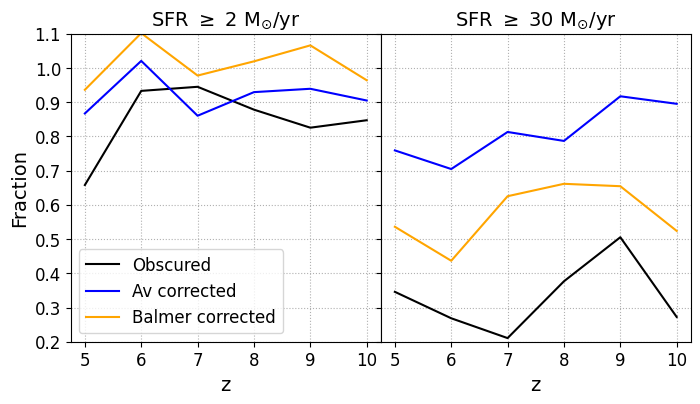

In [21]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(8, 4), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs = axs.ravel()

zs = np.arange(5,11,1)

axs[0].plot(zs, obsc_frac[0], color='black', label='Obscured')
# axs[0].fill_between(zs, obsc_frac[0] - obsc_frac_err[0], obsc_frac[0] + obsc_frac_err[0], alpha=0.2, color='black')

axs[0].plot(zs, sfrd_frac_Av[0], color='blue', label='Av corrected')
# axs[0].fill_between(zs, sfrd_frac_Av[0] - sfrd_frac_Av_err[0], sfrd_frac_Av[0] + sfrd_frac_Av_err[0], alpha=0.4, color='blue')

axs[0].plot(zs, sfrd_frac_balmer[0], color='orange', label='Balmer corrected')
# axs[0].fill_between(zs, sfrd_frac_balmer[0] - sfrd_frac_balmer_err[0], sfrd_frac_balmer[0] + sfrd_frac_balmer_err[0], alpha=0.4, color='brown')

axs[1].plot(zs, obsc_frac[1], color='black')
# axs[1].fill_between(zs, obsc_frac[1] - obsc_frac_err[1], obsc_frac[1] + obsc_frac_err[1], alpha=0.2, color='black')

axs[1].plot(zs, sfrd_frac_Av[1], color='blue')
# axs[1].fill_between(zs, sfrd_frac_Av[1] - sfrd_frac_Av_err[1], sfrd_frac_Av[1] + sfrd_frac_Av_err[1], alpha=0.4, color='blue')

axs[1].plot(zs, sfrd_frac_balmer[1], color='orange')
# axs[1].fill_between(zs, sfrd_frac_balmer[1] - sfrd_frac_balmer_err[1], sfrd_frac_balmer[1] + sfrd_frac_balmer_err[1], alpha=0.4, color='orange')

axs[0].legend(fontsize=12, frameon=True)

for ax in axs:
    ax.grid(ls='dotted')
    ax.set_ylim(0.2, 1.1)
    ax.set_yticks(np.arange(0.2, 1.11, 0.1))
    ax.set_xlabel('z', fontsize=14)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

axs[0].set_ylabel('Fraction', fontsize=14)
axs[0].set_title(r'SFR $\geq$ 2 M$_{\odot}$/yr', fontsize=14)   
axs[1].set_title(r'SFR $\geq$ 30 M$_{\odot}$/yr', fontsize=14)   

fig.subplots_adjust(hspace=0,wspace=0)
plt.savefig('plots/sfrd_frac.png', dpi=300, bbox_inches='tight')
